In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gym import spaces

Episode 1: Total Reward = -15, Epsilon = 1.0
Episode 2: Total Reward = 25, Epsilon = 0.9990104948350412
Episode 3: Total Reward = -90, Epsilon = 0.9980219786806598
Episode 4: Total Reward = 20, Epsilon = 0.9970344505483393
Episode 5: Total Reward = -20, Epsilon = 0.9960479094505515
Episode 6: Total Reward = -10, Epsilon = 0.9950623544007555
Episode 7: Total Reward = 5, Epsilon = 0.9940777844133959
Episode 8: Total Reward = -20, Epsilon = 0.9930941985039028
Episode 9: Total Reward = 20, Epsilon = 0.99211159568869
Episode 10: Total Reward = 20, Epsilon = 0.9911299749851548
Episode 11: Total Reward = 25, Epsilon = 0.9901493354116764
Episode 12: Total Reward = -40, Epsilon = 0.9891696759876151
Episode 13: Total Reward = -20, Epsilon = 0.9881909957333113
Episode 14: Total Reward = -10, Epsilon = 0.9872132936700847
Episode 15: Total Reward = 20, Epsilon = 0.9862365688202333
Episode 16: Total Reward = 5, Epsilon = 0.985260820207032
Episode 17: Total Reward = 10, Epsilon = 0.9842860468547323
E

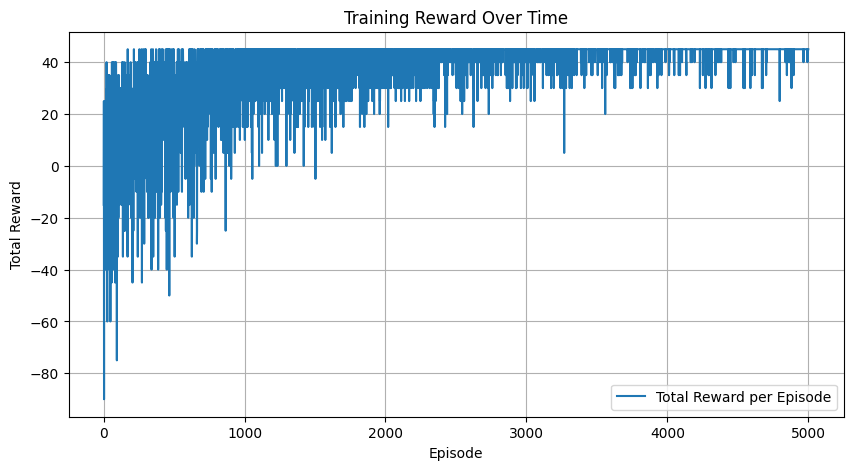

In [2]:
class TrainEnvironment(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(TrainEnvironment, self).__init__()
        self.stations = ['A', 'B', 'C', None]  # None represents the end of the line
        self.num_trains = 3
        self.train_positions = np.zeros(self.num_trains, dtype=int)  # Indexes of stations for trains
        self.distances = {'AB': 8.8, 'BC': 5.8, 'BA': 8.8, 'CB': 5.8}  # Distances between stations in km
        self.train_speed = {0: 70, 1: 100, 2: 100}  # Speed in km/h

        # Define action and observation space
        self.action_space = spaces.MultiDiscrete([2] * self.num_trains)
        self.observation_space = spaces.Discrete(len(self.stations) ** self.num_trains)

    def reset(self):
        self.train_positions = np.zeros(self.num_trains, dtype=int)  # All trains start at 'A'
        return self.get_state_index()

    def get_state_index(self):
        # Convert state represented by positions into an index for Q-table
        return int(np.dot(self.train_positions, [len(self.stations)**i for i in range(self.num_trains)]))

    def step(self, actions):
        done = False
        reward = 0

        for i in range(self.num_trains):
            if self.train_positions[i] >= len(self.stations) - 2:
                # Train has reached its final destination
                continue

            if actions[i] == 1:  # Action 1: move to next station
                current_station_index = self.train_positions[i]
                if current_station_index < len(self.stations) - 2:
                    next_station_index = current_station_index + 1
                    if next_station_index not in self.train_positions:
                        next_station = self.stations[next_station_index]
                        current_station = self.stations[current_station_index]
                        distance_key = current_station + next_station

                        if distance_key in self.distances:
                            expected_time = self.distances[distance_key] / self.train_speed[i]  # Time in hours
                            actual_time = 1 / 60  # Each step is considered as 1 minute

                            self.train_positions[i] = next_station_index
                            delay = (actual_time - expected_time) * 60  # Delay in minutes
                            if delay > 0:
                                reward -= 10  # Penalty for delay
                            else:
                                reward += 10  # Small reward for being on time or early
                    else:
                        reward -= 5  # Penalty for waiting
            elif actions[i] == 0:  # Action 0: stay
                reward -= 5  # Penalty for waiting

        # Check if all trains are at their final positions (station C or None)
        if all(pos >= len(self.stations) - 2 for pos in self.train_positions):
            done = True

        # Remove trains that have reached their final destination (C) from the track
        for i in range(self.num_trains):
            if self.train_positions[i] == len(self.stations) - 2:
                self.train_positions[i] = len(self.stations) - 1  # Move train to None (end of the line)

        return self.get_state_index(), reward, done, {}

    def render(self, mode='human'):
        # Print train positions
        print("Train Positions:", self.train_positions)

def q_learning(env, episodes, alpha, gamma, epsilon_start, epsilon_end, epsilon_decay):
    num_states = env.observation_space.n
    num_actions = env.action_space.nvec[0]  # Two actions: move or stay
    q_table = np.zeros((num_states, env.num_trains, num_actions))
    episode_rewards = []  # Store rewards for each episode

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0  # Reset total reward for the episode

        # Update epsilon for the current episode
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-epsilon_decay * episode)

        while not done:
            actions = []
            for i in range(env.num_trains):
                if np.random.rand() < epsilon:  # Explore
                    action = np.random.randint(num_actions)
                else:  # Exploit
                    action = np.argmax(q_table[state, i])
                actions.append(action)

            new_state, reward, done, _ = env.step(actions)
            total_reward += reward  # Accumulate reward for the episode

            for i in range(env.num_trains):
                old_value = q_table[state, i, actions[i]]
                next_max = np.max(q_table[new_state, i])
                new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                q_table[state, i, actions[i]] = new_value

            state = new_state

        episode_rewards.append(total_reward)  # Append reward for the episode

        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {epsilon}")

    # Plot total rewards per episode
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, episodes + 1), episode_rewards, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Reward Over Time')
    plt.legend()
    plt.grid()
    plt.show()

    return q_table


def test_agent(env, q_table, episodes):
    num_actions = env.action_space.nvec[0]  # Two actions: move or stay

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0  # Reset total reward for the episode
        steps = 0

        train_positions_over_time = []  # Store positions at each step

        # Record the initial positions before taking any actions
        train_positions_over_time.append(list(env.train_positions))  # Record initial train positions

        while not done:
            actions = []
            for i in range(env.num_trains):
                action = np.argmax(q_table[state, i])  # Choose the best action from Q-table
                actions.append(action)

            new_state, reward, done, _ = env.step(actions)
            total_reward += reward  # Accumulate reward for the episode
            state = new_state
            steps += 1

            train_positions_over_time.append(list(env.train_positions))  # Record train positions after each step

            env.render()  # Optional: render the environment to see train positions at each step

        # Convert positions to numpy array for easy plotting
        train_positions_over_time = np.array(train_positions_over_time)

        # Plot train positions over time
        plt.figure(figsize=(10, 5))
        for i in range(env.num_trains):
            plt.plot(train_positions_over_time[:, i], label=f'Train {i}')
        plt.xlabel('Step')
        plt.ylabel('Station Index')
        plt.title(f'Train Positions Over Time (Test Episode {episode + 1})')
        plt.legend()
        plt.grid()
        plt.show()

        print(f"Test Episode {episode + 1}: Total Reward = {total_reward}, Steps = {steps}")

def plot_q_values_heatmap(q_table, state, num_trains):
    num_actions = q_table.shape[2]
    
    # Create a 2D array of Q-values for the given state
    q_values_matrix = np.zeros((num_trains, num_actions))
    for i in range(num_trains):
        q_values_matrix[i, :] = q_table[state, i, :]

    plt.figure(figsize=(10, 8))
    sns.heatmap(q_values_matrix, annot=True, cmap="YlGnBu", xticklabels=range(num_actions), yticklabels=[f'Train {i}' for i in range(num_trains)])
    plt.xlabel('Action')
    plt.ylabel('Train')
    plt.title(f'Q-Values Heatmap for State {state}')
    plt.show()

# Parameters
alpha = 0.1
gamma = 0.9
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.001
training_episodes = 5000
testing_episodes = 1

# Create Gym environment
env = TrainEnvironment()

# Training with dynamic epsilon
q_table = q_learning(env, training_episodes, alpha, gamma, epsilon_start, epsilon_end, epsilon_decay)


Train Positions: [1 0 0]
Train Positions: [3 1 0]
Train Positions: [3 3 1]
Train Positions: [3 3 3]


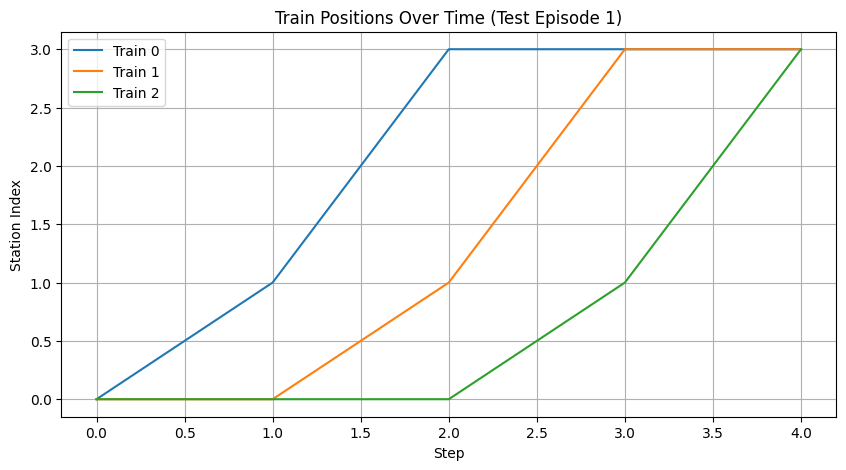

Test Episode 1: Total Reward = 45, Steps = 4


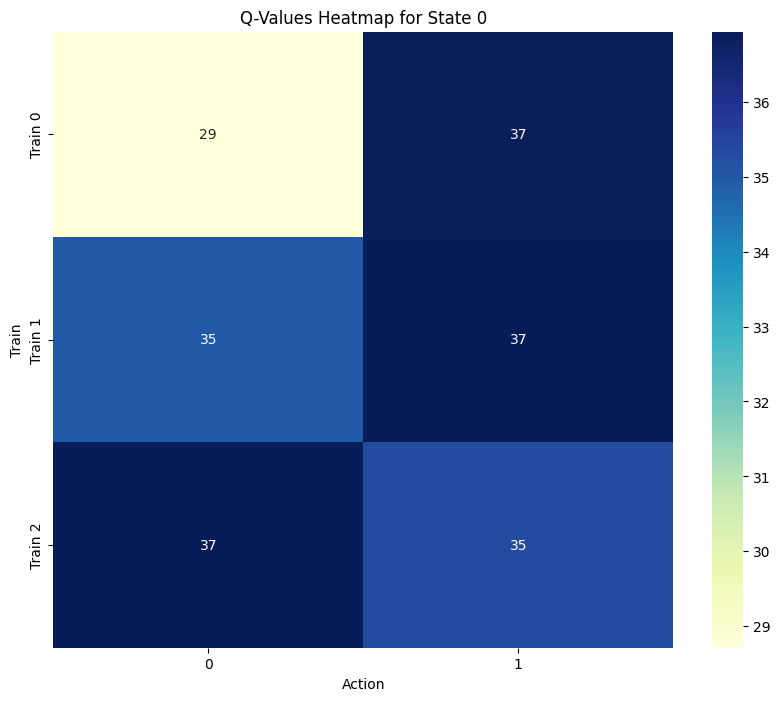

In [3]:
# Testing
test_agent(env, q_table, testing_episodes)

# Plot Q-values for a specific state (Example)
state_to_plot = 0  # Replace with any state index you want to visualize
plot_q_values_heatmap(q_table, state_to_plot, env.num_trains)